# Need to reorganize heavily

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ImageNet dimensions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load CIFAR-10 (ID)
cifar10_train = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
cifar10_test = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
cifar10_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)

# Load TinyImageNet (OOD)
tinyimagenet_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
from torchvision.datasets.utils import download_and_extract_archive
#download_and_extract_archive(tinyimagenet_url, download_root="./data")

tinyimagenet_dir = './data/tiny-imagenet-200/train'
tinyimagenet = datasets.ImageFolder(root=tinyimagenet_dir, transform=transform)
tinyimagenet_loader = DataLoader(tinyimagenet, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Feature extractor using ResNet
feature_extractor = models.resnet18(pretrained=True)
feature_extractor.fc = nn.Identity()  # Remove classification layer
feature_extractor = feature_extractor.to(device)
with torch.no_grad():
    features = feature_extractor(images)  # Output shape: (batch_size, 512)

c:\Users\jm65o\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jm65o\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\jm65o/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 27.3MB/s]


NameError: name 'images' is not defined

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class LinearTransform(nn.Module):
    def __init__(self, input_dim):
        super(LinearTransform, self).__init__()
        self.fc = nn.Linear(input_dim, input_dim, bias=False)

    def forward(self, x):
        return self.fc(x)

input_dim = 512  # ResNet feature size
D1 = Decoder(input_dim).to(device)
D2 = Decoder(input_dim).to(device)
W = LinearTransform(input_dim).to(device)

In [ ]:
def total_loss(v, Wv, D1, D2, lambda_reg=0.01, beta=0.1):
    """
    Combined reconstruction and softmax loss for ID/OOD separation.
    """
    # Reconstruction loss for features
    L1 = torch.mean((v - D1(Wv)) ** 2)
    
    # Reconstruction loss for logits
    L2 = torch.mean((Wv - D2(torch.softmax(Wv, dim=1))) ** 2)
    
    # Softmax-based regularization (encourage confidence for ID)
    softmax_scores = torch.softmax(Wv, dim=1)  # Shape: (batch_size, num_classes)
    log_softmax_scores = torch.log(softmax_scores + 1e-8)  # Numerical stability
    L_reg = -torch.mean(torch.sum(softmax_scores * log_softmax_scores, dim=1))
    
    # Combine losses
    return L1 + L2 + lambda_reg * L_reg + beta * torch.mean(1 - torch.max(softmax_scores, dim=1)[0])

In [ ]:
# Optimizer
optimizer = optim.SGD(list(D1.parameters()) + list(D2.parameters()) + list(W.parameters()), lr=1e-3)

# Training step
def train_step(features, labels_onehot):
    D1.train()
    D2.train()
    W.train()

    # Forward pass
    Wv = W(features)  # Now Wv has shape (batch_size, 10)
    loss = total_loss(features, Wv, labels_onehot, D1, D2)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
for epoch in range(100):  # Number of epochs
    running_loss = 0.0
    for images, _ in cifar10_loader:  # Ignore labels
        images = images.to(device)

        # Extract features using ResNet
        features = feature_extractor(images)  # Output: (batch_size, 512)

        # Transform features using W
        Wv = W(features)  # Output: (batch_size, 512)

        # Calculate total loss
        loss = total_loss(features, Wv, D1, D2)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(cifar10_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

Epoch 1, Average Loss: 1.7430
Epoch 2, Average Loss: 1.6026
Epoch 3, Average Loss: 1.5232
Epoch 4, Average Loss: 1.3982
Epoch 5, Average Loss: 1.2398
Epoch 6, Average Loss: 1.1037
Epoch 7, Average Loss: 1.0145
Epoch 8, Average Loss: 0.9613
Epoch 9, Average Loss: 0.9288
Epoch 10, Average Loss: 0.9077


In [27]:
def calculate_reconstruction_errors(data_loader, feature_extractor, D1, W, device):
    errors = []
    feature_extractor.eval()  # Ensure the feature extractor is in evaluation mode
    D1.eval()  # Ensure the decoder is in evaluation mode
    W.eval()  # Ensure the transformation layer is in evaluation mode
    
    with torch.no_grad():  # Disable gradient computation for inference
        for images, _ in data_loader:  # Ignore labels
            images = images.to(device)
            features = feature_extractor(images)  # Extract features
            Wv = W(features)  # Apply linear transformation
            reconstructed_features = D1(Wv)  # Reconstruct features
            # Compute reconstruction error (mean squared error per image)
            error = torch.mean((features - reconstructed_features) ** 2, dim=1)  # Reconstruction error
            errors.extend(error.cpu().numpy())  # Collect errors in CPU memory
    return errors
# # Calculate errors for ID and OOD datasets
# id_errors = calculate_reconstruction_errors(cifar10_loader, feature_extractor, D1, W, device)
# ood_errors = calculate_reconstruction_errors(tinyimagenet_loader, feature_extractor, D1, W, device)

# # Set the OOD detection threshold
# mean_id_error = np.mean(id_errors)
# std_id_error = np.std(id_errors)
# threshold = mean_id_error + 2 * std_id_error  # Example threshold


In [ ]:
print(mean_id_error)

0.62360865


In [ ]:
mean_ood_error = np.mean(ood_errors)
print(mean_ood_error)

0.5837027


In [ ]:
print(threshold)

0.7766264528036118


In [ ]:
# True Positive (correctly identified OOD samples)
true_positives = sum([1 for error in ood_errors if error > threshold])

# True Negative (correctly identified ID samples)
true_negatives = sum([1 for error in id_errors if error <= threshold])

# Total samples
total_id = len(id_errors)
total_ood = len(ood_errors)

# Metrics
ood_detection_rate = true_positives / total_ood * 100
id_classification_rate = true_negatives / total_id * 100

print(f"Correctly identified OOD samples: {true_positives} out of {total_ood} ({ood_detection_rate:.2f}%)")
print(f"Correctly classified ID samples: {true_negatives} out of {total_id} ({id_classification_rate:.2f}%)")

Correctly identified OOD samples: 7412 out of 100000 (7.41%)
Correctly classified ID samples: 48163 out of 50000 (96.33%)


In [101]:
import matplotlib.pyplot as plt

plt.hist(id_errors, bins=50, alpha=0.5, label='ID (CIFAR-10)')
plt.hist(ood_errors, bins=50, alpha=0.5, label='OOD (TinyImageNet)')
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Errors for ID vs OOD')
plt.legend()
plt.show()


NameError: name 'id_errors' is not defined

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
import numpy as np
from sklearn.metrics import roc_auc_score
from torchvision.datasets.utils import download_and_extract_archive

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ensure CIFAR-10 dataset is downloaded
try:
    cifar10_train = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    cifar10_test = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    cifar10_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)
except Exception as e:
    print(f"Error downloading CIFAR-10: {e}")

# Ensure TinyImageNet dataset is downloaded
try:
    tinyimagenet_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    tinyimagenet_dir = './data/tiny-imagenet-200'
    if not os.path.exists(tinyimagenet_dir):
        print("Downloading TinyImageNet...")
        download_and_extract_archive(tinyimagenet_url, download_root="./data")

    tinyimagenet = datasets.ImageFolder(root=os.path.join(tinyimagenet_dir, 'train'), transform=transform)
    tinyimagenet_loader = DataLoader(tinyimagenet, batch_size=64, shuffle=True)
except Exception as e:
    print(f"Error downloading TinyImageNet: {e}")

# Feature extractor using ResNet
feature_extractor = models.resnet18(pretrained=True)
feature_extractor.fc = nn.Identity()  # Remove classification layer
feature_extractor = feature_extractor.to(device)

# Define decoders and transformation
class Decoder(nn.Module):
    def __init__(self, input_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class LinearTransform(nn.Module):
    def __init__(self, input_dim):
        super(LinearTransform, self).__init__()
        self.fc = nn.Linear(input_dim, input_dim, bias=False)

    def forward(self, x):
        return self.fc(x)

input_dim = 512
D1 = Decoder(input_dim).to(device)
D2 = Decoder(input_dim).to(device)
W = LinearTransform(input_dim).to(device)

# Define total loss
def total_loss(v, Wv, D1, D2, lambda_reg=0.01, beta=0.1):
    L1 = torch.mean((v - D1(Wv)) ** 2)
    L2 = torch.mean((Wv - D2(torch.softmax(Wv, dim=1))) ** 2)
    softmax_scores = torch.softmax(Wv, dim=1)
    log_softmax_scores = torch.log(softmax_scores + 1e-8)
    L_reg = -torch.mean(torch.sum(softmax_scores * log_softmax_scores, dim=1))
    return L1 + L2 + lambda_reg * L_reg + beta * torch.mean(1 - torch.max(softmax_scores, dim=1)[0])

# Optimizer
optimizer = optim.Adam(list(D1.parameters()) + list(D2.parameters()) + list(W.parameters()), lr=1e-3)

# Training loop
def train_model(num_epochs=50):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in cifar10_loader:
            images = images.to(device)

            with torch.no_grad():
                features = feature_extractor(images)

            optimizer.zero_grad()
            Wv = W(features)
            loss = total_loss(features, Wv, D1, D2)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(cifar10_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

def calculate_reconstruction_errors(data_loader, feature_extractor, D1, W, device):
    errors = []
    with torch.no_grad():
        for images, _ in data_loader:  # Ignore labels
            images = images.to(device)
            features = feature_extractor(images)  # Extract features
            Wv = W(features)  # Transform features
            reconstructed_features = D1(Wv)  # Reconstruct features
            error = torch.mean((features - reconstructed_features) ** 2, dim=1)  # Reconstruction error
            errors.extend(error.cpu().numpy())
    return np.array(errors)

# Run training
train_model(num_epochs=100)
# Calculate errors for CIFAR-10 (ID) and TinyImageNet (OOD)
print("Calculating reconstruction errors for CIFAR-10 (ID)...")
id_errors = calculate_reconstruction_errors(cifar10_loader, feature_extractor, D1, W, device)

print("Calculating reconstruction errors for TinyImageNet (OOD)...")
ood_errors = calculate_reconstruction_errors(tinyimagenet_loader, feature_extractor, D1, W, device)

# Set OOD detection threshold
mean_id_error = np.mean(id_errors)
std_id_error = np.std(id_errors)
threshold = mean_id_error + 2 * std_id_error  # Example threshold

print(f"Mean ID Error: {mean_id_error:.4f}, Std ID Error: {std_id_error:.4f}, Threshold: {threshold:.4f}")

# Evaluate OOD detection
true_labels = [0] * len(id_errors) + [1] * len(ood_errors)  # 0 for ID, 1 for OOD
predicted_labels = [1 if e > threshold else 0 for e in np.concatenate([id_errors, ood_errors])]

# Calculate metrics
accuracy = np.mean([pred == true for pred, true in zip(predicted_labels, true_labels)]) * 100
auc_score = roc_auc_score(true_labels, np.concatenate([id_errors, ood_errors]))

print(f"OOD Detection Accuracy: {accuracy:.2f}%")
print(f"AUC Score: {auc_score:.4f}")

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


c:\Users\jm65o\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jm65o\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 0.0087
Epoch 2, Loss: 0.0015
Epoch 3, Loss: 0.0011
Epoch 4, Loss: 0.0008
Epoch 5, Loss: 0.0007
Epoch 6, Loss: 0.0006
Epoch 7, Loss: 0.0006
Epoch 8, Loss: 0.0005
Epoch 9, Loss: 0.0005
Epoch 10, Loss: 0.0004
Anomaly Detection Threshold: 0.0009
Anomalies Detected: 9839 / 10000
Anomaly Detection Rate: 98.39%


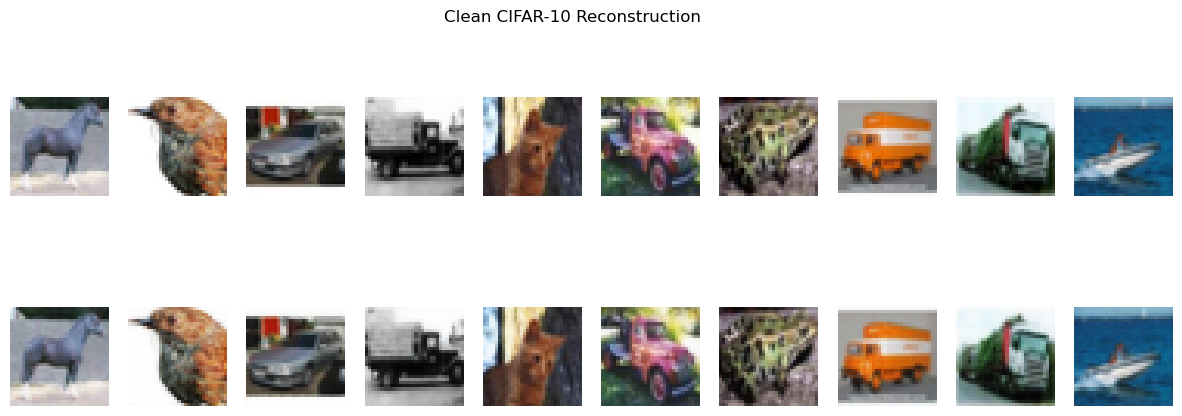

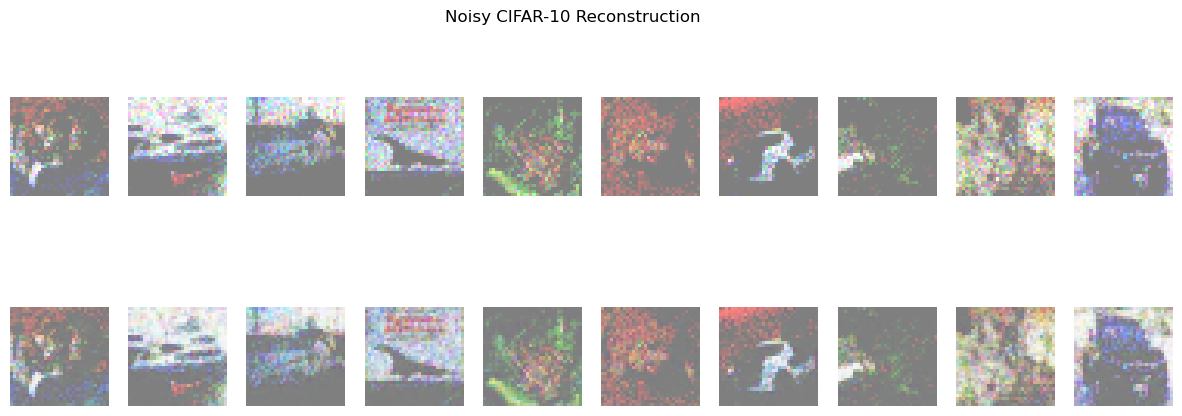

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10
cifar10_train = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
cifar10_test = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
cifar10_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)

# Generate CIFAR-10 Noisy Dataset
def add_noise(images, noise_factor=0.1):
    noisy_imgs = images + noise_factor * torch.randn(*images.shape)
    return torch.clip(noisy_imgs, 0., 1.)

cifar10_test_noisy = [
    (add_noise(img, noise_factor=0.2), label) for img, label in cifar10_test
]
cifar10_noisy_loader = DataLoader(cifar10_test_noisy, batch_size=64, shuffle=False)

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# Initialize model, loss, and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Train the Autoencoder
def train_autoencoder():
    autoencoder.train()
    for epoch in range(10):  # Adjust the number of epochs as needed
        running_loss = 0.0
        for images, _ in cifar10_loader:
            images = images.to(device)
            optimizer.zero_grad()
            reconstructed = autoencoder(images)
            loss = criterion(reconstructed, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(cifar10_loader):.4f}")

# Train the autoencoder
train_autoencoder()

# Evaluate Reconstruction Errors
def calculate_reconstruction_errors(data_loader):
    autoencoder.eval()
    errors = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            reconstructed = autoencoder(images)
            error = torch.mean((images - reconstructed) ** 2, dim=(1, 2, 3))
            errors.extend(error.cpu().numpy())
    return np.array(errors)

# Calculate errors for clean and noisy CIFAR-10
clean_errors = calculate_reconstruction_errors(cifar10_loader)
noisy_errors = calculate_reconstruction_errors(cifar10_noisy_loader)

# Set anomaly detection threshold
mean_clean_error = np.mean(clean_errors)
std_clean_error = np.std(clean_errors)
threshold = mean_clean_error + 2 * std_clean_error

# Evaluate anomaly detection
anomalies_detected = noisy_errors > threshold
anomaly_rate = np.sum(anomalies_detected) / len(noisy_errors) * 100

print(f"Anomaly Detection Threshold: {threshold:.4f}")
print(f"Anomalies Detected: {np.sum(anomalies_detected)} / {len(noisy_errors)}")
print(f"Anomaly Detection Rate: {anomaly_rate:.2f}%")

# Visualization (optional)
def visualize_reconstruction(loader, title=""):
    autoencoder.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        images = images.to(device)
        reconstructed = autoencoder(images)
        # Plot original and reconstructed
        fig, axes = plt.subplots(2, 10, figsize=(15, 5))
        for i in range(10):
            axes[0, i].imshow((images[i].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5))
            axes[0, i].axis("off")
            axes[1, i].imshow((reconstructed[i].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5))
            axes[1, i].axis("off")
        plt.suptitle(title)
        plt.show()

visualize_reconstruction(cifar10_loader, "Clean CIFAR-10 Reconstruction")
visualize_reconstruction(cifar10_noisy_loader, "Noisy CIFAR-10 Reconstruction")

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 0.0091
Epoch 2, Loss: 0.0016
Epoch 3, Loss: 0.0011
Epoch 4, Loss: 0.0009
Epoch 5, Loss: 0.0007
Epoch 6, Loss: 0.0006
Epoch 7, Loss: 0.0006
Epoch 8, Loss: 0.0005
Epoch 9, Loss: 0.0005
Epoch 10, Loss: 0.0004
Anomaly Detection Threshold: 0.0010
Anomalies Detected: 7020 / 10000
Anomaly Detection Rate: 70.20%


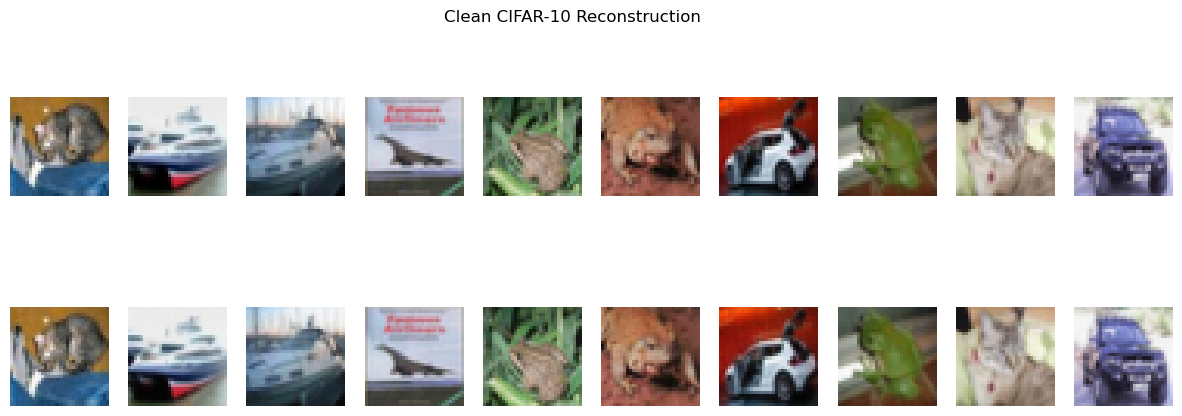

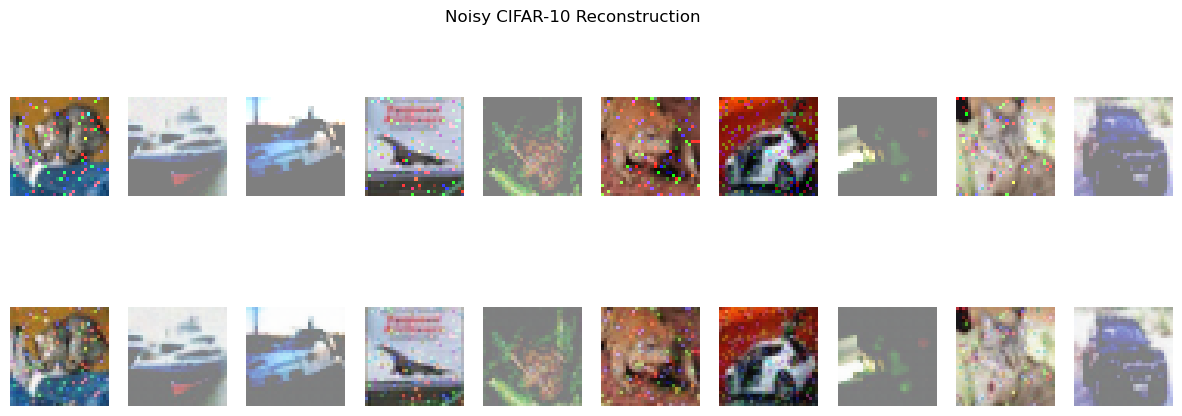

NameError: name 'true_labels' is not defined

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10
cifar10_train = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
cifar10_test = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
cifar10_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False)

# Noise functions
def add_gaussian_noise(images, noise_factor=0.1):
    """
    Add Gaussian noise to the images.
    Ensure that noise tensor is on the same device as images.
    """
    noise = noise_factor * torch.randn(*images.shape, device=images.device)  # Ensure noise is on the same device
    noisy_images = images + noise
    return torch.clip(noisy_images, 0., 1.)


def add_salt_and_pepper_noise(images, prob=0.05):
    noisy_images = images.clone()
    num_pixels = images.numel()
    num_salt = int(prob * num_pixels * 0.5)
    num_pepper = int(prob * num_pixels * 0.5)
    
    # Add salt
    indices = torch.randint(0, num_pixels, (num_salt,))
    noisy_images.view(-1)[indices] = 1.0
    
    # Add pepper
    indices = torch.randint(0, num_pixels, (num_pepper,))
    noisy_images.view(-1)[indices] = 0.0
    
    return noisy_images

def add_fgsm_attack(model, images, labels, epsilon=0.03):
    """
    Add FGSM adversarial noise to images.
    """
    images = images.to(device)  # Move images to the same device as the model
    labels = labels.to(device)  # Move labels to the same device as the model
    images.requires_grad = True
    
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()
    perturbed_images = images + epsilon * images.grad.sign()
    
    return torch.clip(perturbed_images, 0, 1)

def add_brightness_contrast(images, brightness_factor=1.2, contrast_factor=1.5):
    return transforms.functional.adjust_brightness(
        transforms.functional.adjust_contrast(images, contrast_factor),
        brightness_factor
    )

def add_pixel_dropout(images, dropout_prob=0.1):
    """
    Apply pixel dropout to the images.
    Ensure the mask tensor is created on the same device as images.
    """
    mask = (torch.rand(images.shape, device=images.device) > dropout_prob).float()
    return images * mask

# Custom noisy CIFAR-10 dataset
def create_noisy_dataset(data_loader, model=None):
    """
    Create a noisy dataset by applying various noise functions.
    """
    noisy_dataset = []
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        for i in range(len(images)):
            # Randomly choose a noise function
            noise_fn = np.random.choice([
                add_gaussian_noise,
                add_salt_and_pepper_noise,
                add_pixel_dropout,
                add_brightness_contrast,
                lambda imgs: add_fgsm_attack(model, imgs, labels[i:i+1]) if model else imgs
            ])
            noisy_image = noise_fn(images[i].unsqueeze(0))  # Add noise to single image
            noisy_dataset.append((noisy_image.squeeze(0), labels[i]))
    return noisy_dataset

# Define a dummy model for FGSM (optional, replace with your classifier)
class DummyModel(nn.Module):
    def __init__(self):
        super(DummyModel, self).__init__()
        self.fc = nn.Linear(3 * 32 * 32, 10)

    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))

dummy_model = DummyModel().to(device)

# Generate noisy CIFAR-10 test dataset
cifar10_noisy_dataset = create_noisy_dataset(cifar10_test_loader, model=dummy_model)
cifar10_noisy_loader = DataLoader(cifar10_noisy_dataset, batch_size=64, shuffle=False)

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# Initialize model, loss, and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Train the Autoencoder
def train_autoencoder(epochs=10):
    autoencoder.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in cifar10_loader:
            images = images.to(device)
            optimizer.zero_grad()
            reconstructed = autoencoder(images)
            loss = criterion(reconstructed, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(cifar10_loader):.4f}")

# Train the autoencoder
train_autoencoder(epochs=10)

# Evaluate Reconstruction Errors
def calculate_reconstruction_errors(data_loader):
    autoencoder.eval()
    errors = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            reconstructed = autoencoder(images)
            error = torch.mean((images - reconstructed) ** 2, dim=(1, 2, 3))
            errors.extend(error.cpu().numpy())
    return np.array(errors)

# Calculate errors for clean and noisy CIFAR-10
clean_errors = calculate_reconstruction_errors(cifar10_test_loader)
noisy_errors = calculate_reconstruction_errors(cifar10_noisy_loader)

# Set anomaly detection threshold
mean_clean_error = np.mean(clean_errors)
std_clean_error = np.std(clean_errors)
threshold = mean_clean_error + 2 * std_clean_error

# Evaluate anomaly detection
anomalies_detected = noisy_errors > threshold
anomaly_rate = np.sum(anomalies_detected) / len(noisy_errors) * 100

print(f"Anomaly Detection Threshold: {threshold:.4f}")
print(f"Anomalies Detected: {np.sum(anomalies_detected)} / {len(noisy_errors)}")
print(f"Anomaly Detection Rate: {anomaly_rate:.2f}%")

# Visualization (optional)
def visualize_reconstruction(loader, title=""):
    autoencoder.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        images = images.to(device)
        reconstructed = autoencoder(images)
        # Plot original and reconstructed
        fig, axes = plt.subplots(2, 10, figsize=(15, 5))
        for i in range(10):
            axes[0, i].imshow((images[i].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5))
            axes[0, i].axis("off")
            axes[1, i].imshow((reconstructed[i].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5))
            axes[1, i].axis("off")
        plt.suptitle(title)
        plt.show()

visualize_reconstruction(cifar10_test_loader, "Clean CIFAR-10 Reconstruction")
visualize_reconstruction(cifar10_noisy_loader, "Noisy CIFAR-10 Reconstruction")

tensor([[[-0.8196, -0.8510, -0.8353,  ...,  0.5686,  0.5608,  0.5451],
         [-0.8196, -0.8510, -0.8353,  ...,  0.6078,  0.6000,  0.5843],
         [-0.8196, -0.8431, -0.8196,  ...,  0.6549,  0.6314,  0.6157],
         ...,
         [ 0.5216,  0.3882,  0.3804,  ...,  0.1686,  0.1608,  0.1059],
         [ 0.3490,  0.2314,  0.2941,  ...,  0.0980,  0.1686,  0.1922],
         [ 0.1843,  0.0510,  0.1294,  ...,  0.1686,  0.2157,  0.1765]],

        [[-0.8510, -0.8353, -0.8745,  ...,  0.2157,  0.1922,  0.1843],
         [-0.8431, -0.8431, -0.8667,  ...,  0.3176,  0.2863,  0.2784],
         [-0.8431, -0.8431, -0.8431,  ...,  0.3569,  0.3255,  0.3020],
         ...,
         [ 0.5373,  0.4039,  0.4039,  ...,  0.0275,  0.0196, -0.0353],
         [ 0.3882,  0.2627,  0.3333,  ..., -0.0431,  0.0196,  0.0510],
         [ 0.2314,  0.0980,  0.1843,  ...,  0.0353,  0.0745,  0.0353]],

        [[-0.8196, -0.7804, -0.8510,  ..., -0.0196, -0.0431, -0.0588],
         [-0.8118, -0.7882, -0.8431,  ...,  0

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

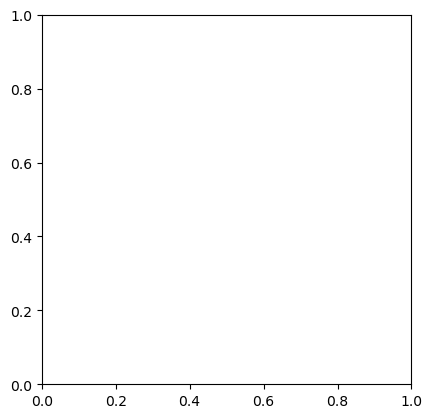

In [7]:
mean_noisy_error = np.mean(noisy_errors)
print(mean_noisy_error)

0.0056305546


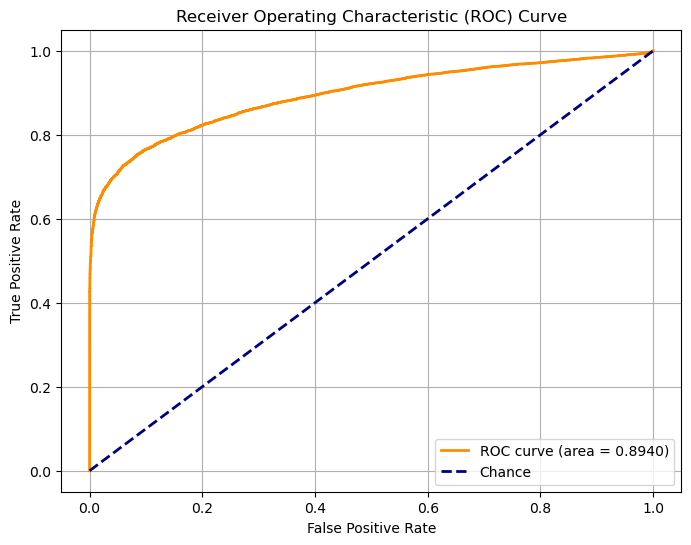

FPR at TPR 95%: 0.6419


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Calculate false positive rate, true positive rate, and thresholds
true_labels = [0] * len(clean_errors) + [1] * len(noisy_errors)  # 0 for ID, 1 for OOD
fpr, tpr, thresholds = roc_curve(true_labels, np.concatenate([clean_errors, noisy_errors]))

# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

tpr_target = 0.95
closest_index = np.argmin(np.abs(tpr - tpr_target))
fpr_at_tpr_95 = fpr[closest_index]
print(f"FPR at TPR 95%: {fpr_at_tpr_95:.4f}")

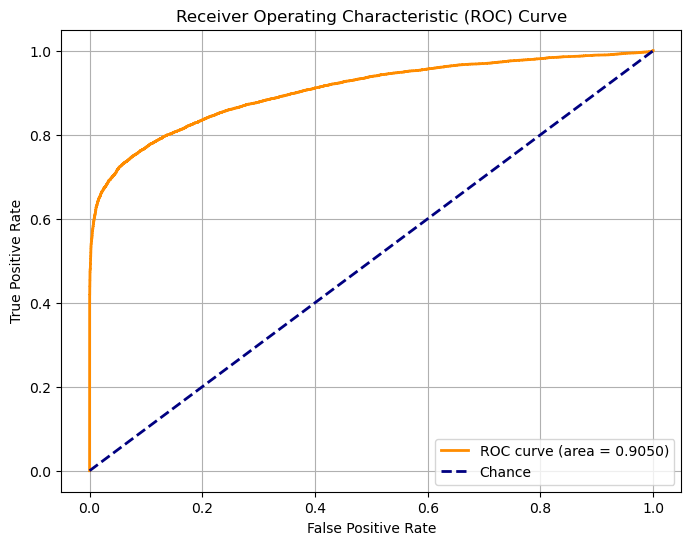

In [183]:
# Correctly concatenate labels and errors
clean_errors = calculate_reconstruction_errors(cifar10_test_loader)  # Should match the test dataset size
noisy_errors = calculate_reconstruction_errors(cifar10_noisy_loader)  # Should match the noisy dataset size

# Define true labels with matching sizes
true_labels_clean = np.zeros(clean_errors.shape)  # Clean labels
true_labels_noisy = np.ones(noisy_errors.shape)  # Noisy labels
true_labels = np.concatenate([true_labels_clean, true_labels_noisy])  # Combine labels

# Combine errors with matching sizes
all_errors = np.concatenate([clean_errors, noisy_errors])  # Combine errors

# Ensure sizes match
assert true_labels.shape[0] == all_errors.shape[0], "Mismatch in label and error sizes!"

# Calculate ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(true_labels, all_errors)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [167]:
# Evaluate Reconstruction Errors
def calculate_reconstruction_errors(data_loader):
    autoencoder.eval()
    errors = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            reconstructed = autoencoder(images)
            error = torch.mean((images - reconstructed) ** 2, dim=(1, 2, 3))
            errors.extend(error.cpu().numpy())
    return np.array(errors)

Anomaly Detection Threshold: 0.0003
OOD Samples Detected: 7940 / 100000
OOD Detection Rate: 7.94%


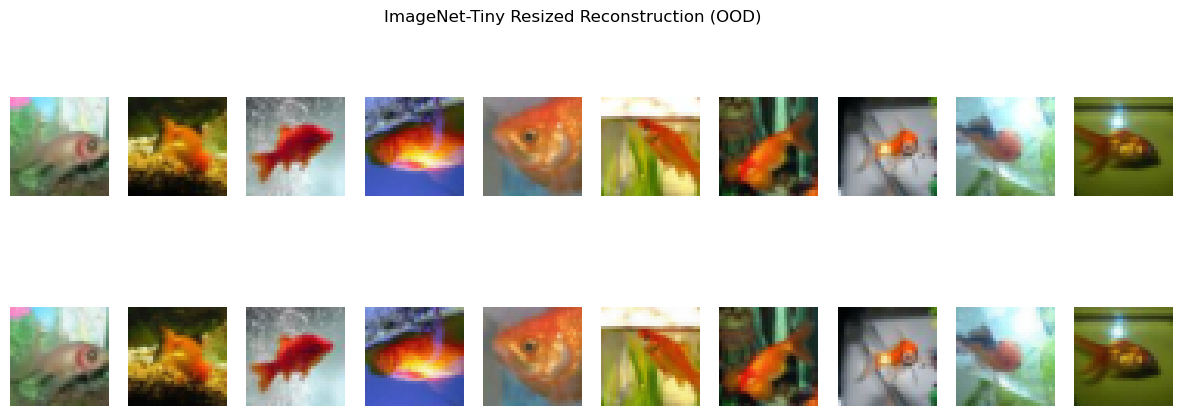

OOD Detection Accuracy: 15.89%
AUC Score: 0.5486


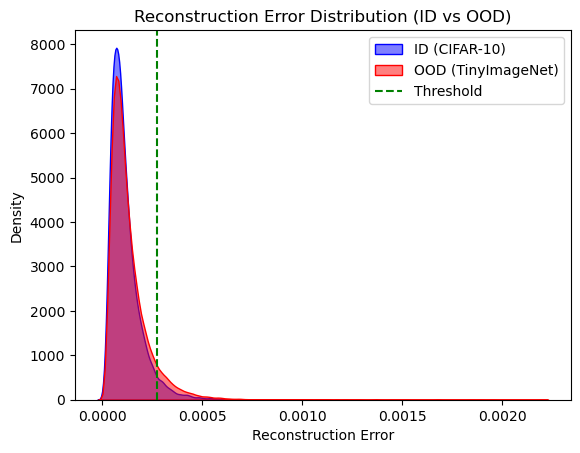

In [ ]:
# Import necessary libraries
import os
from torchvision.datasets.utils import download_and_extract_archive
import seaborn as sns

# Load TinyImageNet Resized (OOD) Dataset
imagenet_tiny_dir = './data/tiny-imagenet-200'
if not os.path.exists(imagenet_tiny_dir):
    tinyimagenet_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    download_and_extract_archive(tinyimagenet_url, download_root="./data")

transform_ood = transforms.Compose([
    transforms.Resize((32, 32)),  # Match CIFAR-10 dimensions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

imagenet_tiny_dataset = datasets.ImageFolder(root=os.path.join(imagenet_tiny_dir, 'train'), transform=transform_ood)
imagenet_tiny_loader = DataLoader(imagenet_tiny_dataset, batch_size=64, shuffle=False)

# Train the Autoencoder (Retain existing code for training)
#train_autoencoder(epochs=10)

# Calculate Reconstruction Errors for OOD (ImageNet-Tiny Resized)
id_errors = calculate_reconstruction_errors(cifar10_test_loader)
imagenet_tiny_errors = calculate_reconstruction_errors(imagenet_tiny_loader)
ood_errors = imagenet_tiny_errors

# Set OOD Detection Threshold (Using CIFAR-10 Reconstruction Errors)
threshold = mean_clean_error + 2 * std_clean_error

# Evaluate OOD Detection
ood_detections = imagenet_tiny_errors > threshold
ood_detection_rate = np.sum(ood_detections) / len(imagenet_tiny_errors) * 100

print(f"Anomaly Detection Threshold: {threshold:.4f}")
print(f"OOD Samples Detected: {np.sum(ood_detections)} / {len(imagenet_tiny_errors)}")
print(f"OOD Detection Rate: {ood_detection_rate:.2f}%")

# Visualization (Optional)
def visualize_ood(loader, title=""):
    autoencoder.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        images = images.to(device)
        reconstructed = autoencoder(images)
        # Plot original and reconstructed
        fig, axes = plt.subplots(2, 10, figsize=(15, 5))
        for i in range(10):
            axes[0, i].imshow((images[i].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5))
            axes[0, i].axis("off")
            axes[1, i].imshow((reconstructed[i].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5))
            axes[1, i].axis("off")
        plt.suptitle(title)
        plt.show()

visualize_ood(imagenet_tiny_loader, "ImageNet-Tiny Resized Reconstruction (OOD)")


# Evaluate OOD detection
true_labels = [0] * len(id_errors) + [1] * len(ood_errors)  # 0 for ID, 1 for OOD
predicted_labels = [1 if e > threshold else 0 for e in np.concatenate([id_errors, ood_errors])]

# Calculate metrics
accuracy = np.mean([pred == true for pred, true in zip(predicted_labels, true_labels)]) * 100
auc_score = roc_auc_score(true_labels, np.concatenate([id_errors, ood_errors]))

print(f"OOD Detection Accuracy: {accuracy:.2f}%")
print(f"AUC Score: {auc_score:.4f}")

sns.kdeplot(id_errors, label="ID (CIFAR-10)", fill=True, color="blue", alpha=0.5)
sns.kdeplot(ood_errors, label="OOD (TinyImageNet)", fill=True, color="red", alpha=0.5)
plt.axvline(threshold, color='green', linestyle='--', label="Threshold")
plt.legend()
plt.title("Reconstruction Error Distribution (ID vs OOD)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.savefig("error_distribution.png")
plt.show()

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, np.concatenate([id_errors, ood_errors]))

# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

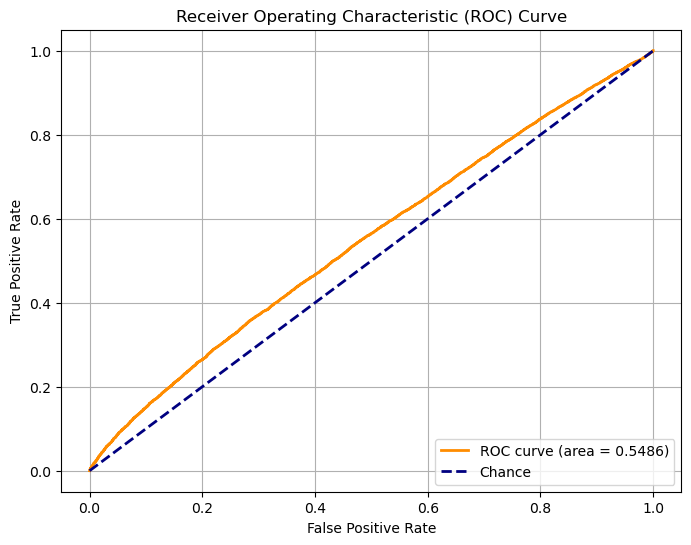

In [175]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, np.concatenate([id_errors, ood_errors]))

# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Yibo + Hendrycks Anomaly Detection

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10
cifar10_train = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
cifar10_test = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
cifar10_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False)

# Noise functions (as previously defined)
def add_gaussian_noise(images, noise_factor=0.1):
    noise = noise_factor * torch.randn(*images.shape, device=images.device)
    noisy_images = images + noise
    return torch.clip(noisy_images, 0., 1.)

def add_salt_and_pepper_noise(images, prob=0.05):
    noisy_images = images.clone()
    num_pixels = images.numel()
    num_salt = int(prob * num_pixels * 0.5)
    num_pepper = int(prob * num_pixels * 0.5)
    indices_salt = torch.randint(0, num_pixels, (num_salt,))
    indices_pepper = torch.randint(0, num_pixels, (num_pepper,))
    noisy_images.view(-1)[indices_salt] = 1.0
    noisy_images.view(-1)[indices_pepper] = 0.0
    return noisy_images

def add_pixel_dropout(images, dropout_prob=0.1):
    mask = (torch.rand(images.shape, device=images.device) > dropout_prob).float()
    return images * mask

# Custom noisy CIFAR-10 dataset
def create_noisy_dataset(data_loader):
    noisy_dataset = []
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        for i in range(len(images)):
            noise_fn = np.random.choice([
                add_gaussian_noise,
                add_salt_and_pepper_noise,
                add_pixel_dropout
            ])
            noisy_image = noise_fn(images[i].unsqueeze(0)).squeeze(0)
            noisy_dataset.append((noisy_image, labels[i]))
    return noisy_dataset

# Generate noisy CIFAR-10 test dataset
cifar10_noisy_dataset = create_noisy_dataset(cifar10_test_loader)
cifar10_noisy_loader = DataLoader(cifar10_noisy_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Feature extractor (ResNet18)
feature_extractor = models.resnet18(pretrained=True)
feature_extractor.fc = nn.Identity()  # Remove the classification layer
feature_extractor = feature_extractor.to(device)

# Decoders and linear transformation
class Decoder(nn.Module):
    def __init__(self, input_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class LinearTransform(nn.Module):
    def __init__(self, input_dim):
        super(LinearTransform, self).__init__()
        self.fc = nn.Linear(input_dim, input_dim, bias=False)

    def forward(self, x):
        return self.fc(x)

input_dim = 512
D1 = Decoder(input_dim).to(device)
D2 = Decoder(input_dim).to(device)
W = LinearTransform(input_dim).to(device)

c:\Users\jm65o\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jm65o\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:

# Yibo + Hendrycks
# def total_loss(features, Wv, D1, D2, lambda_reg=0.01):
#     reconstruction_loss = torch.mean((features - D1(Wv)) ** 2)
#     logits = D2(Wv)
#     softmax_scores = torch.softmax(logits, dim=1)
#     confidence_loss = -torch.mean(torch.sum(softmax_scores * torch.log(softmax_scores + 1e-8), dim=1))
#     return reconstruction_loss + lambda_reg * confidence_loss


# def total_loss(v, Wv, D1, D2, lambda_reg=0.01, beta=0.1):
#     L1 = torch.mean((v - D1(Wv)) ** 2)
#     L2 = torch.mean((Wv - D2(torch.softmax(Wv, dim=1))) ** 2)
#     softmax_scores = torch.softmax(Wv, dim=1)
#     log_softmax_scores = torch.log(softmax_scores + 1e-8)
#     L_reg = -torch.mean(torch.sum(softmax_scores * log_softmax_scores, dim=1))
#     return L1 + L2 + lambda_reg * L_reg + beta * torch.mean(1 - torch.max(softmax_scores, dim=1)[0])



# Yibo
def total_loss(v, Wv, D1, lambda_reg=0.01):
    """
    Simplified reconstruction-based loss.
    """
    # Reconstruction loss for features
    L1 = torch.mean((v - D1(Wv)) ** 2)
    return L1 + lambda_reg * torch.mean(Wv ** 2)


optimizer = optim.Adam(list(D1.parameters()) + list(D2.parameters()) + list(W.parameters()), lr=1e-3)

In [7]:
def train_model(num_epochs=50):
    feature_extractor.eval()  # Keep feature extractor frozen
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in cifar10_loader:
            images = images.to(device)
            with torch.no_grad():
                features = feature_extractor(images)

            optimizer.zero_grad()
            Wv = W(features)
            loss = total_loss(features, Wv, D1, lambda_reg=0.02)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(cifar10_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Train the model
train_model(num_epochs=5)

Epoch 1/5, Loss: 0.0637
Epoch 2/5, Loss: 0.0452
Epoch 3/5, Loss: 0.0405
Epoch 4/5, Loss: 0.0382
Epoch 5/5, Loss: 0.0370


In [9]:
def calculate_reconstruction_errors_anomaly(data_loader, autoencoder, device):
    autoencoder.eval()
    errors = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            reconstructed = autoencoder(images)
            error = torch.mean((images - reconstructed) ** 2, dim=(1, 2, 3))
            errors.extend(error.cpu().numpy())
    return np.array(errors)

In [10]:
# Calculate physical reconstruction errors for CIFAR-10 (clean)
print("Calculating physical reconstruction errors for CIFAR-10 (clean)...")
clean_errors = calculate_reconstruction_errors_anomaly(cifar10_test_loader, autoencoder, device)

# Calculate physical reconstruction errors for CIFAR-10 (adversarial/noisy)
print("Calculating physical reconstruction errors for CIFAR-10 (noisy/adversarial)...")
adversarial_errors = calculate_reconstruction_errors_anomaly(cifar10_noisy_loader, autoencoder, device)

Calculating physical reconstruction errors for CIFAR-10 (clean)...


NameError: name 'autoencoder' is not defined

In [11]:
# Set anomaly detection threshold
mean_clean_error = np.mean(clean_errors)
std_clean_error = np.std(clean_errors)
threshold = mean_clean_error + 2 * std_clean_error  # Example threshold

print(f"Mean Clean Error: {mean_clean_error:.4f}, Std Clean Error: {std_clean_error:.4f}, Threshold: {threshold:.4f}")

# Evaluate anomaly detection
true_labels = [0] * len(clean_errors) + [1] * len(adversarial_errors)  # 0 for clean, 1 for adversarial
predicted_labels = [1 if e > threshold else 0 for e in np.concatenate([clean_errors, adversarial_errors])]

# Calculate metrics
accuracy = np.mean([pred == true for pred, true in zip(predicted_labels, true_labels)]) * 100
auc_score = roc_auc_score(true_labels, np.concatenate([clean_errors, adversarial_errors]))

print(f"Anomaly Detection Accuracy: {accuracy:.2f}%")
print(f"AUC Score: {auc_score:.4f}")

NameError: name 'clean_errors' is not defined

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, np.concatenate([clean_errors, adversarial_errors]))

# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
tpr_target = 0.95
closest_index = np.argmin(np.abs(tpr - tpr_target))
fpr_at_tpr_95 = fpr[closest_index]
print(f"FPR at TPR 95%: {fpr_at_tpr_95:.4f}")

NameError: name 'true_labels' is not defined

In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_and_extract_archive

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ensure CIFAR-10 dataset is downloaded
cifar10_train = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
cifar10_test = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
cifar10_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)

# Ensure TinyImageNet dataset is downloaded
tinyimagenet_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
tinyimagenet_dir = './data/tiny-imagenet-200'
if not os.path.exists(tinyimagenet_dir):
    print("Downloading TinyImageNet...")
    download_and_extract_archive(tinyimagenet_url, download_root="./data")

tinyimagenet = datasets.ImageFolder(root=os.path.join(tinyimagenet_dir, 'train'), transform=transform)
tinyimagenet_loader = DataLoader(tinyimagenet, batch_size=64, shuffle=True)

# Feature extractor using ResNet
feature_extractor = models.resnet18(pretrained=True)
feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

# Define decoders and transformation
class Decoder(nn.Module):
    def __init__(self, input_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class LinearTransform(nn.Module):
    def __init__(self, input_dim):
        super(LinearTransform, self).__init__()
        self.fc = nn.Linear(input_dim, input_dim, bias=False)

    def forward(self, x):
        return self.fc(x)

input_dim = 512
D1 = Decoder(input_dim).to(device)
D2 = Decoder(input_dim).to(device)
W = LinearTransform(input_dim).to(device)

# Define total loss
def total_loss(v, Wv, D1, D2, lambda_reg=0.01, beta=0.1):
    L1 = torch.mean((v - D1(Wv)) ** 2)
    L2 = torch.mean((Wv - D2(torch.softmax(Wv, dim=1))) ** 2)
    softmax_scores = torch.softmax(Wv, dim=1)
    log_softmax_scores = torch.log(softmax_scores + 1e-8)
    L_reg = -torch.mean(torch.sum(softmax_scores * log_softmax_scores, dim=1))
    return L1 + L2 + lambda_reg * L_reg + beta * torch.mean(1 - torch.max(softmax_scores, dim=1)[0])

optimizer = optim.SGD(
    list(D1.parameters()) + list(D2.parameters()) + list(W.parameters()), 
    lr=0.01, momentum=0.9, weight_decay=1e-4
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


# Save model checkpoint
def save_checkpoint(epoch, model, optimizer, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

# Training loop
def train_model(num_epochs=50, checkpoint_interval=10):
    print("Begin Training!")
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in cifar10_loader:
            images = images.to(device)

            with torch.no_grad():
                features = feature_extractor(images)

            optimizer.zero_grad()
            Wv = W(features)
            loss = total_loss(features, Wv, D1, D2)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(cifar10_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Step the scheduler
        scheduler.step()

        # Save checkpoint
        if (epoch + 1) % checkpoint_interval == 0:
            save_checkpoint(epoch + 1, D1, optimizer, filename=f"checkpoint_epoch_{epoch + 1}.pth")

# Calculate reconstruction errors
def calculate_reconstruction_errors(data_loader, feature_extractor, D1, W, device):
    errors = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            features = feature_extractor(images)
            Wv = W(features)
            reconstructed_features = D1(Wv)
            error = torch.mean((features - reconstructed_features) ** 2, dim=1)
            errors.extend(error.cpu().numpy())
    return np.array(errors)

# Run training
train_model(num_epochs=10)

# Calculate errors
print("Calculating reconstruction errors for CIFAR-10 (ID)...")
id_errors = calculate_reconstruction_errors(cifar10_loader, feature_extractor, D1, W, device)

print("Calculating reconstruction errors for TinyImageNet (OOD)...")
ood_errors = calculate_reconstruction_errors(tinyimagenet_loader, feature_extractor, D1, W, device)

# Set OOD detection threshold
mean_id_error = np.mean(id_errors)
std_id_error = np.std(id_errors)
threshold = mean_id_error + 2 * std_id_error

# Visualize distributions
import seaborn as sns

sns.kdeplot(id_errors, label="ID", fill=True, color="blue", alpha=0.5)
sns.kdeplot(ood_errors, label="OOD", fill=True, color="red", alpha=0.5)
plt.axvline(threshold, color='green', linestyle='--', label="Threshold")
plt.legend()
plt.title("Reconstruction Error Distribution (ID vs OOD)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.savefig("error_distribution.png")
plt.show()

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


c:\Users\jm65o\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jm65o\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Begin Training!


KeyboardInterrupt: 

In [12]:
# print("Calculating reconstruction errors for CIFAR-10 (ID)...")
# id_errors = calculate_reconstruction_errors(cifar10_loader, feature_extractor, D1, W, device)

# print("Calculating reconstruction errors for TinyImageNet (OOD)...")
# ood_errors = calculate_reconstruction_errors(tinyimagenet_loader, feature_extractor, D1, W, device)

mean_id_error = np.mean(id_errors)
std_id_error = np.std(id_errors)
threshold = mean_id_error + 5 * std_id_error # Example threshold

print(f"Mean ID Error: {mean_id_error:.4f}, Std ID Error: {std_id_error:.4f}, Threshold: {threshold:.4f}")

# Evaluate OOD detection
true_labels = [0] * len(id_errors) + [1] * len(ood_errors)  # 0 for ID, 1 for OOD
predicted_labels = [1 if e > threshold else 0 for e in np.concatenate([id_errors, ood_errors])]

# Calculate metrics
accuracy = np.mean([pred == true for pred, true in zip(predicted_labels, true_labels)]) * 100
auc_score = roc_auc_score(true_labels, np.concatenate([id_errors, ood_errors]))

print(f"OOD Detection Accuracy: {accuracy:.2f}%")
print(f"AUC Score: {auc_score:.4f}")

sns.kdeplot(id_errors, label="ID (CIFAR-10)", fill=True, color="blue", alpha=0.5)
sns.kdeplot(ood_errors, label="OOD (TinyImageNet)", fill=True, color="red", alpha=0.5)
plt.axvline(threshold, color='green', linestyle='--', label="Threshold")
plt.legend()
plt.title("Reconstruction Error Distribution (ID vs OOD)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.savefig("error_distribution.png")
plt.show()

NameError: name 'id_errors' is not defined

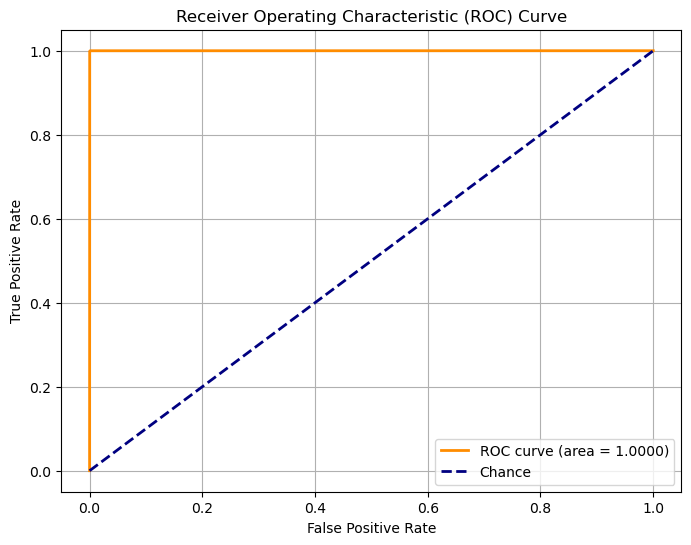

In [164]:
fpr, tpr, thresholds = roc_curve(true_labels, np.concatenate([id_errors, ood_errors]))

# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()